In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

<h3>Import the Data</h3>

In [4]:
# Import the data
results = pd.DataFrame(pd.read_csv('./results.csv'))
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 6 columns):
home_team     4560 non-null object
away_team     4560 non-null object
home_goals    4560 non-null float64
away_goals    4560 non-null float64
result        4560 non-null object
season        4560 non-null object
dtypes: float64(2), object(4)
memory usage: 213.8+ KB


<h3>Points Table</h3>

In [5]:
# Create the Points Table for a season
def Points_Table(season):
    # Make away team results
    # Make home team results
    away_results = results[results['season'] == season].copy()
    home_results = away_results.copy()
    
    # Away results
    away_results['team'] = away_results['away_team']
    away_results['played'] = 1
    away_results['points'] = away_results['result'].map({'D': 1, 'H': 0, 'A': 3})
    away_results['gf'] = away_results['away_goals'].astype(int)
    away_results['ga'] = away_results['home_goals'].astype(int)
    away_results.drop(['home_team', 'away_team', 'home_goals', 'away_goals', 'season', 'result'], axis=1, inplace=True)
    
    # Home results
    home_results['team'] = home_results['home_team']
    home_results['played'] = 1
    home_results['points'] = home_results['result'].map({'D': 1, 'H': 3, 'A': 0})
    home_results['gf'] = home_results['home_goals'].astype(int)
    home_results['ga'] = home_results['away_goals'].astype(int)
    home_results.drop(['home_team', 'away_team', 'home_goals', 'away_goals', 'season', 'result'], axis=1, inplace=True)
    
    # Make Points Table
    pts_table = away_results.copy().append(home_results)
    pts_table = pts_table.groupby(['team'], as_index=False).sum()
    pts_table = pts_table.sort_values(by=['points', 'gf'], ascending=False)
    pts_table['gd'] = pts_table['gf'] - pts_table['ga']
    
    return pts_table.reset_index(drop=True)

In [6]:
Points_Table('2017-2018')

,team,played,points,gf,ga,gd
0,Manchester City,38,100,106,27,79
1,Manchester United,38,81,68,28,40
2,Tottenham Hotspur,38,77,74,36,38
3,Liverpool,38,75,84,38,46
4,Chelsea,38,70,62,38,24
5,Arsenal,38,63,74,51,23
6,Burnley,38,54,36,39,-3
7,Everton,38,49,44,58,-14
8,Leicester City,38,47,56,60,-4
9,AFC Bournemouth,38,44,45,61,-16


<h3>Relegated and Promoted Teams</h3>

In [7]:
# Relegated teams are last three teams in a season
def Relegated_Teams(season):
    pts_table = Points_Table(season)
    return pts_table[17:]


# Promoted teams are the new three teams which qualified from tier 2
def Promoted_Teams(season):
    prev_season = (int(season[:season.find('-')])-1, int(season[season.find('-')+1:])-1)
    prev_season = str(prev_season[0]) + '-' + str(prev_season[1])
    
    # Extract the teams in two seasons
    teams_prev_season = results[results['season'] == prev_season]['home_team'].unique()
    teams_season = results[results['season'] == season]['home_team'].unique()
    promoted_teams = np.setdiff1d(teams_season, teams_prev_season)
    
    pts_table = Points_Table(season)
    return pts_table[pts_table['team'].isin(promoted_teams)]

In [8]:
Promoted_Teams('2010-2011')

,team,played,points,gf,ga,gd
9,West Bromwich Albion,38,47,56,71,-15
11,Newcastle United,38,46,56,57,-1
17,Blackpool,38,39,55,78,-23


<h3>Team Analysis over the years</h3>

In [9]:
# Team Performance over the years
def Team_Performance(team):
    # Make a customised team results dataframe
    team_result = results[(results['home_team'] == team) | (results['away_team'] == team)].copy()
    
    # Add and modify the columns
    team_result['P'] = 1
    team_result['gf'] = np.where((team_result['home_team'] == team), team_result['home_goals'], 
                                 team_result['away_goals']).astype(int)
    team_result['ga'] = np.where((team_result['away_team'] == team), team_result['home_goals'], 
                                 team_result['away_goals']).astype(int)
    
    # Home Wins, Away Wins and Draws
    team_result.loc[(team_result['home_team'] == team) & (team_result['result'] == 'H'), 'HW'] = np.int(1)
    team_result.loc[(team_result['away_team'] == team) & (team_result['result'] == 'A'), 'AW'] = np.int(1)
    team_result.loc[(team_result['result'] == 'D'), 'D'] = 1
    
    drop_columns = ['home_team', 'away_team', 'home_goals', 'away_goals', 'result']
    season_perf = team_result.fillna(0).drop(drop_columns, axis=1).groupby(['season'], as_index=False).sum()
    season_perf['W'] = season_perf['HW'] + season_perf['AW']
    season_perf['L'] = season_perf['P'] - season_perf['W'] - season_perf['D']
    season_perf['gd'] = season_perf['gf'] - season_perf['ga']
    season_perf['pts'] = season_perf['W'] * 3 + season_perf['D']
    
    # Typecast the columns and sequence
    season_perf[['HW', 'AW', 'D', 'W', 'L', 'pts']] = season_perf[['HW', 'AW', 'D', 'W', 'L', 'pts']].astype(int)
    season_perf = season_perf[['season', 'P', 'pts', 'W', 'D', 'L', 'gf', 'ga', 'gd', 'HW', 'AW']]
    
    return season_perf

In [10]:
# Get the team performance over the seasons
Team_Performance('Manchester United')

,season,P,pts,W,D,L,gf,ga,gd,HW,AW
0,2006-2007,38,89,28,5,5,83,27,56,15,13
1,2007-2008,38,87,27,6,5,80,22,58,17,10
2,2008-2009,38,90,28,6,4,68,24,44,16,12
3,2009-2010,38,85,27,4,7,86,28,58,16,11
4,2010-2011,38,80,23,11,4,78,37,41,18,5
5,2011-2012,38,89,28,5,5,89,33,56,15,13
6,2012-2013,38,89,28,5,5,86,43,43,16,12
7,2013-2014,38,64,19,7,12,64,43,21,9,10
8,2014-2015,38,70,20,10,8,62,37,25,14,6
9,2015-2016,38,66,19,9,10,49,35,14,12,7


<h3>Plotting the team performance</h3>

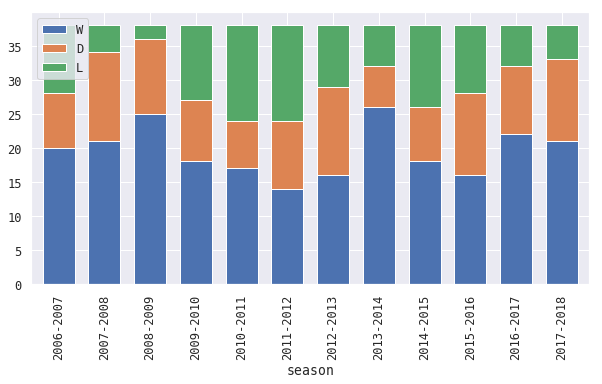

In [11]:
team = 'Liverpool'
sns.set(style='darkgrid', palette='deep', font='monospace', font_scale=1.1)
Team_Performance(team).plot(kind='bar', x='season', y=['W', 'D', 'L'], stacked=True, figsize=(10,5), width=0.7)

<h3>Comparison of two teams for seasons</h3>

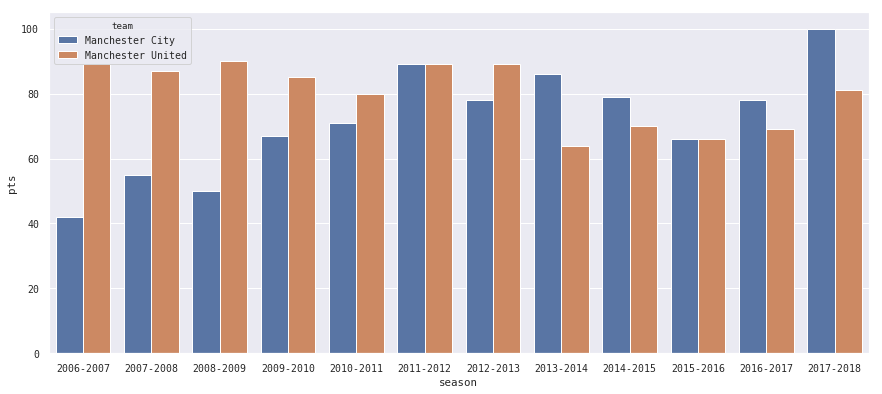

In [12]:
# Compare the wins of two teams
teams = ['Manchester City', 'Manchester United']
performances = {team: Team_Performance(team) for team in teams}
for team in teams:
    performances[team]['team'] = team
comparison = performances[teams[0]].copy().append(performances[teams[1]])

# Plot the comparison
sns.set(style='darkgrid', palette='deep', font='monospace', font_scale=0.9, rc={'figure.figsize':(14.7,6.27)})
sns.barplot(x='season', y='pts', hue='team', data=comparison)

<h3>Total values for all teams</h3>

In [13]:
# Merge team performances in all seasons to give overall stats
def Overall_Stats(team):
    performance = Team_Performance(team)
    performance['team'] = team
    performance.drop(['season'], axis=1, inplace=True)
    
    # Overall stats
    overall_stats = performance.groupby(['team'], as_index=False).sum()
    overall_stats['w_per'] = (overall_stats['W'] * 100) / overall_stats['P']
    overall_stats['d_per'] = (overall_stats['D'] * 100) / overall_stats['P']
    overall_stats['l_per'] = (overall_stats['L'] * 100) / overall_stats['P']
    overall_stats['hw_per'] = (overall_stats['HW'] * 200) / overall_stats['P']
    overall_stats['aw_per'] = (overall_stats['AW'] * 200) / overall_stats['P']
    
    # Limit percentage to two decimals
    per_cols = ['w_per', 'l_per', 'd_per', 'hw_per', 'aw_per']
    overall_stats[per_cols] = np.around(overall_stats[per_cols], decimals=2)
    
    return overall_stats

In [14]:
# Total values
def Overview():
    teams = results['home_team'].unique()
    overall = pd.concat([Overall_Stats(team) for team in teams], ignore_index=True)
    return overall

In [15]:
overview = Overview()
overview.head()

,team,P,pts,W,D,L,gf,ga,gd,HW,AW,w_per,d_per,l_per,hw_per,aw_per
0,Sheffield United,38,38,10,8,20,32,55,-23,7,3,26.32,21.05,52.63,36.84,15.79
1,Arsenal,456,872,255,107,94,861,481,380,152,103,55.92,23.46,20.61,66.67,45.18
2,Everton,456,696,185,141,130,652,526,126,121,64,40.57,30.92,28.51,53.07,28.07
3,Newcastle United,380,441,116,93,171,446,581,-135,76,40,30.53,24.47,45.00,40.00,21.05
4,Portsmouth,152,180,47,39,66,165,205,-40,31,16,30.92,25.66,43.42,40.79,21.05


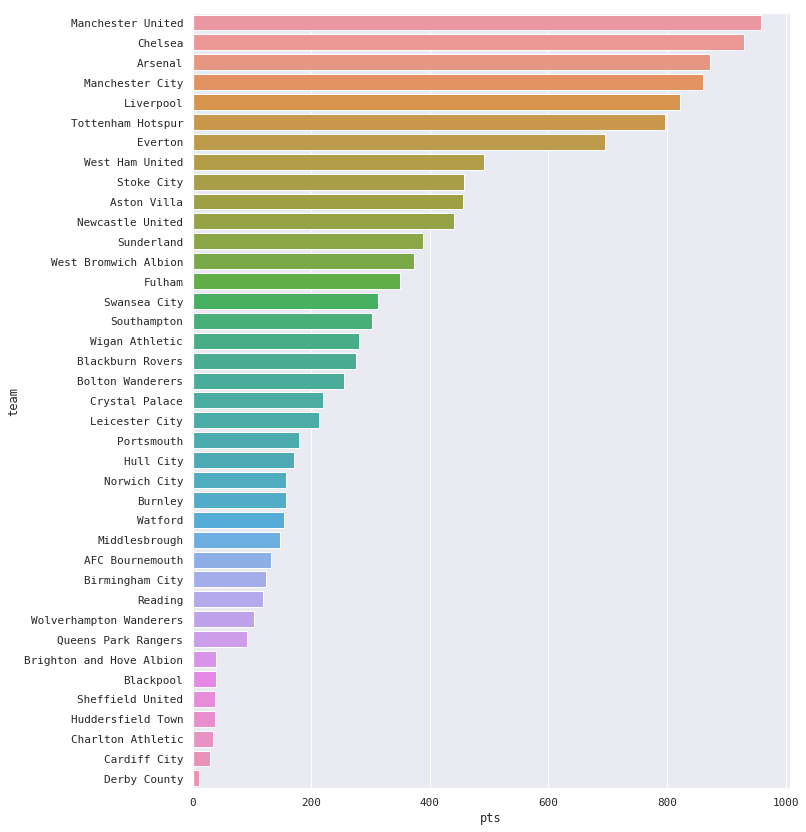

In [141]:
# Plot the comparison
attribute = 'pts'
sns.set(style='darkgrid', palette='deep', font='monospace', font_scale=1.0, rc={'figure.figsize':(10.7,14.27)})
sns.barplot(y='team', x=attribute, data=overview.sort_values(by=[attribute], ascending=False))

<h3>Team Overview Comparison</h3>

In [148]:
def Teams_Comparison(teams):
    teams_overview = pd.concat([overview.loc[(overview['team'] == team)] for team in teams], ignore_index=True)
    return teams_overview

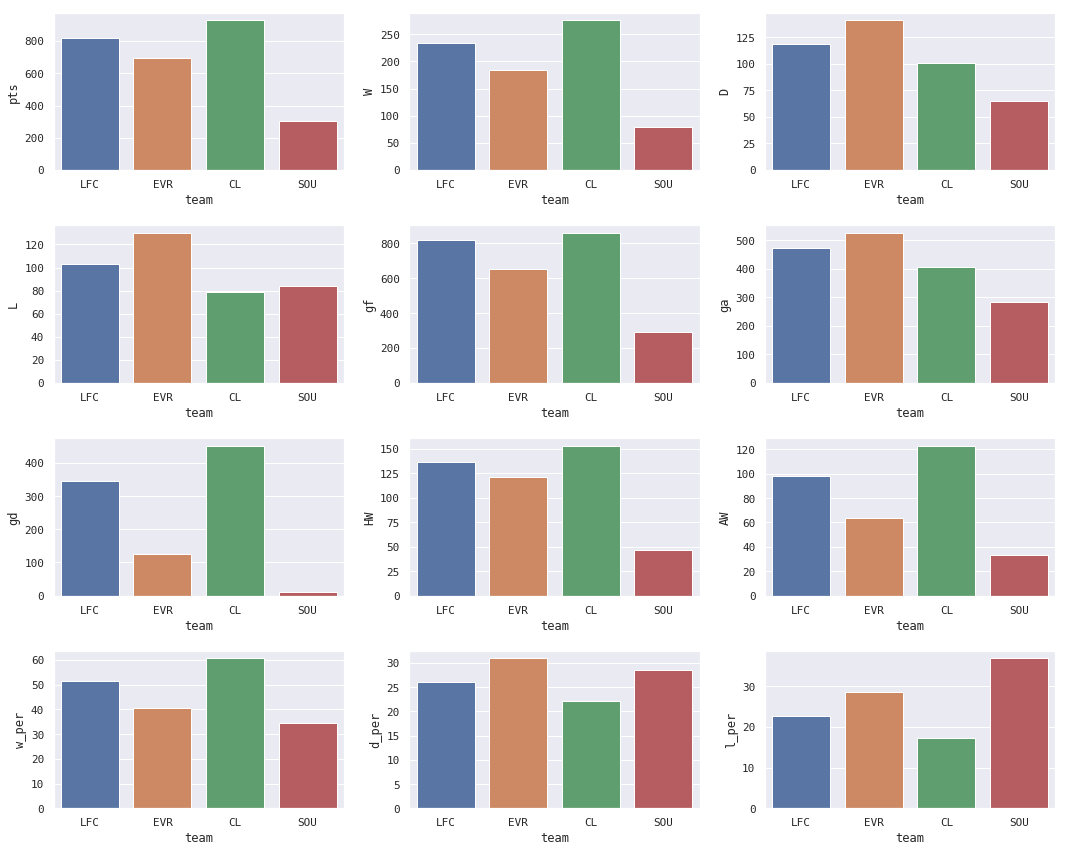

In [155]:
teams = ['Liverpool', 'Everton', 'Chelsea', 'Southampton']
alias = ['LFC', 'EVR', 'CL', 'SOU']
teams_overview = Teams_Comparison(teams)
teams_overview['team'] = np.array(alias)

features = [col for col in teams_overview.columns if (col != 'team') & (col != 'P') & (col != 'alias')]

# Get the rows and columns count to show multiple plots
cols_in_one_row = 3
rows = len(features) // cols_in_one_row
cols = (len(features) % cols_in_one_row) + 1

# Plot the comparisons plots
fig, ax = pyplot.subplots(rows, cols, figsize=(15, cols*4))
sns.reset_orig()
sns.set(style='darkgrid', palette='deep', font='monospace')

for i in range(0, len(features), cols_in_one_row):
    s_index = i
    e_index = i+cols_in_one_row if (i+cols_in_one_row <= len(features)) else (len(features) - i)
    
    for j in range(s_index, e_index):
        val = features[j]
        sns.barplot(data=teams_overview, x='team', y=val, 
                    ax=ax[i//cols_in_one_row][j%cols_in_one_row])

fig.tight_layout()